# A4. Loading sensortran files
This example loads sensortran files. Only single-ended measurements are currently supported.
Sensortran files are in binary format. The library requires the `*BinaryRawDTS.dat` and `*BinaryTemp.dat` files.

In [1]:
import os
import glob
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
from dtscalibration import read_sensortran_files

The example data files are located in `./python-dts-calibration/tests/data`.

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'sensortran_binary')
print(filepath)

..\..\tests\data\sensortran_binary


In [3]:
filepathlist = sorted(glob.glob(os.path.join(filepath, '*.dat')))
filenamelist = [os.path.basename(path) for path in filepathlist]

for fn in filenamelist:
    print(fn)

15_56_47_BinaryRawDTS.dat
15_56_47_BinaryTemp.dat
16_11_31_BinaryRawDTS.dat
16_11_31_BinaryTemp.dat
16_29_23_BinaryRawDTS.dat
16_29_23_BinaryTemp.dat


We will simply load in the binary files

In [4]:
ds = read_sensortran_files(directory=filepath)

3 files were found, each representing a single timestep
Recorded at 11582 points along the cable
The measurement is single ended


The object tries to gather as much metadata from the measurement files as possible (temporal and spatial coordinates, filenames, temperature probes measurements). All other configuration settings are loaded from the first files and stored as attributes of the `DataStore`. Sensortran's data files contain less information than the other manufacturer's devices, one being the acquisition time. The acquisition time is needed for estimating variances, and is set a constant 1s.

In [5]:
print(ds)

<dtscalibration.DataStore>
Sections:                  ()
Dimensions:                (time: 3, x: 11582)
Coordinates:
  * x                      (x) float32 -451.37958 -450.87354 ... 5408.9644
    filename               (time) <U25 '15_56_47_BinaryRawDTS.dat' ... '16_29_23_BinaryRawDTS.dat'
    filename_temp          (time) <U23 '15_56_47_BinaryTemp.dat' ... '16_29_23_BinaryTemp.dat'
    timestart              (time) datetime64[ns] 2009-09-24T00:56:46 ... 2009-09-24T01:29:22
    timeend                (time) datetime64[ns] 2009-09-24T00:56:47 ... 2009-09-24T01:29:23
  * time                   (time) datetime64[ns] 2009-09-24T00:56:47 ... 2009-09-24T01:29:23
    acquisitiontimeFW      (time) timedelta64[ns] 00:00:01 00:00:01 00:00:01
Data variables:
    ST                     (x, time) int32 39040680 39057147 ... 39071213
    AST                    (x, time) int32 39048646 39064414 ... 39407668
    TMP                    (x, time) float64 -273.1 -273.1 ... 82.41 82.71
    referenceTemper

The sensortran files differ from other manufacturers, in that they return the 'counts' of the Stokes and anti-Stokes signals. These are not corrected for offsets, which has to be done manually for proper calibration. 

Based on the data available in the binary files, the library estimates a zero-count to correct the signals, but this is not perfectly accurate or constant over time. For proper calibration, the offsets would have to be incorporated into the calibration routine.

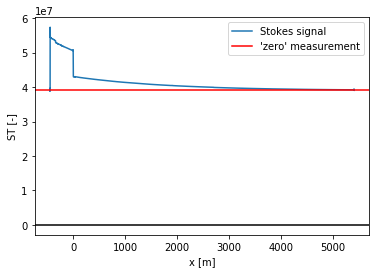

In [6]:
ds0 = ds.isel(time=0)

plt.figure()
ds0.ST.plot(label='Stokes signal')
plt.axhline(ds0.ST_zero.values, c='r', label="'zero' measurement")
plt.legend()
plt.title('')
plt.axhline(c='k')

After a correction and rescaling (for human readability) the data will look more like other manufacturer's devices

In [7]:
ds['ST'] = (ds.ST - ds.ST_zero)/1e4
ds['AST'] = (ds.AST - ds.AST_zero)/1e4

(-50, 500)

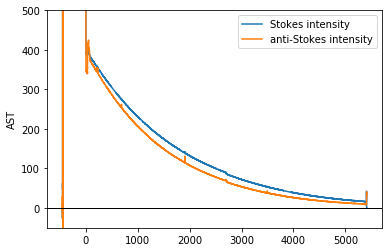

In [8]:
ds.isel(time=0).ST.plot(label='Stokes intensity')
ds.isel(time=0).AST.plot(label='anti-Stokes intensity')
plt.legend()
plt.axhline(c='k', lw=1)
plt.xlabel('')
plt.title('')
plt.ylim([-50,500])